In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import librosa
import matplotlib.pyplot as plt


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/carolinegilbert/Desktop/Purdue/Courses/2024-25/FALL24/ECE570/Project/ECE570-Music-Genre-Classification-CALM/calmenv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/carolinegilbert/Desktop/Purdue/Courses/2024-25/FALL24/ECE570/Project/ECE570-Music-Genre-Classification-CALM/calmenv/lib/python3.11/site-packages/traitlets/config/application

In [2]:
# Configuration
config = {
    'dataset_path': './GTZAN/genres_original',
    'batch_size': 32,
    'learning_rate': 0.1,
    'num_epochs': 150,
    'hidden_dim': 256,
    'latent_dim': 16,
    'input_dim': 64,
    'num_classes': 10,
    'weight_decay': 1e-4,
    'sample_rate': 22050,
    'n_mels': 128,
    'n_fft': 2048,
    'hop_length': 1024,
    'duration': 30,
}

In [3]:
# Data Preprocessing: Convert audio files to Mel spectrograms
def audio_to_mel(filepath, n_mels, n_fft, hop_length):
  try:
    audio, sr = librosa.load(filepath)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
     # Normalize the spectrogram to a range of 0 to 1
    mel_spectrogram = (mel_spectrogram - mel_spectrogram.min()) / (mel_spectrogram.max() - mel_spectrogram.min())

    # Mel spectrogram shape must be (128, 647) - error in paper
    if mel_spectrogram.shape[1] > 647:
      mel_spectrogram = mel_spectrogram[:, :647]
      print(f"Mel spectrogram shape mismatch for file {filepath}. Truncated to {mel_spectrogram.shape}.")
    elif mel_spectrogram.shape[1] < 647:
      mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, 647 - mel_spectrogram.shape[1])), mode='constant')
      print(f"Mel spectrogram shape mismatch for file {filepath}. Padded to {mel_spectrogram.shape}.")

    return mel_spectrogram

  except Exception as e:
    print(f"Error processing file {filepath}: {e}")
    return None

def process_gtzan(dataset_path, n_mels, n_fft, hop_length):
    data, labels = [], []
    genres = os.listdir(dataset_path)
    for genre_idx, genre in enumerate(genres):
        genre_path = os.path.join(dataset_path, genre)
        for filename in os.listdir(genre_path):
            filepath = os.path.join(genre_path, filename)
            mel_spectrogram = audio_to_mel(filepath, n_mels, n_fft, hop_length)
            if mel_spectrogram is not None:
              data.append(mel_spectrogram)
              labels.append(genre_idx)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels


Loaded ./GTZAN/genres_original/classical/classical.00051.wav with sample rate: 22050 and length: 29.99 seconds
Mel spectrogram shape mismatch for file ./GTZAN/genres_original/classical/classical.00051.wav. Padded to (128, 647).


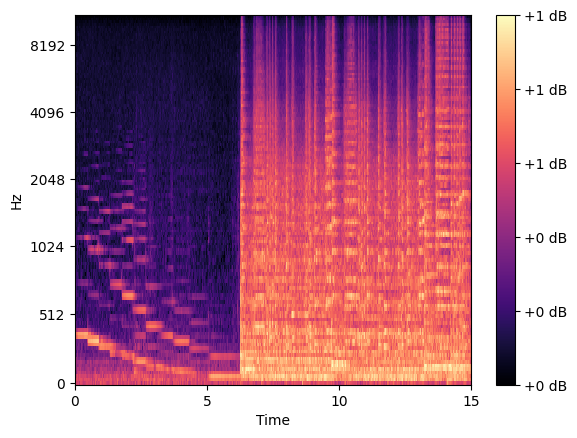

In [4]:
def visualize_mel_spectrogram(mel_spectrogram, title='Mel Spectrogram'):
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spectrogram, aspect='auto', origin='lower')
    plt.title(title)
    plt.xlabel('Mel Bands')
    plt.ylabel('Time Frames')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# Call this function after generating mel_spectrograms
filepath = './GTZAN/genres_original/classical/classical.00051.wav'
audio, sr = librosa.load(filepath)
print(f"Loaded {filepath} with sample rate: {sr} and length: {len(audio) / sr:.2f} seconds")
mel_spectrogram = audio_to_mel(filepath, config['n_mels'], config['n_fft'], config['hop_length'])
librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')



In [5]:
# Load and preprocess GTZAN dataset
data, labels = process_gtzan(config['dataset_path'], config['n_mels'], config['n_fft'], config['hop_length'])

Mel spectrogram shape mismatch for file ./GTZAN/genres_original/disco/disco.00008.wav. Truncated to (128, 647).
Mel spectrogram shape mismatch for file ./GTZAN/genres_original/disco/disco.00005.wav. Truncated to (128, 647).
Mel spectrogram shape mismatch for file ./GTZAN/genres_original/disco/disco.00012.wav. Truncated to (128, 647).
Mel spectrogram shape mismatch for file ./GTZAN/genres_original/disco/disco.00016.wav. Truncated to (128, 647).
Mel spectrogram shape mismatch for file ./GTZAN/genres_original/disco/disco.00003.wav. Truncated to (128, 647).
Mel spectrogram shape mismatch for file ./GTZAN/genres_original/disco/disco.00001.wav. Truncated to (128, 647).
Mel spectrogram shape mismatch for file ./GTZAN/genres_original/disco/disco.00000.wav. Truncated to (128, 647).
Mel spectrogram shape mismatch for file ./GTZAN/genres_original/disco/disco.00014.wav. Padded to (128, 647).
Mel spectrogram shape mismatch for file ./GTZAN/genres_original/classical/classical.00045.wav. Truncated to

/var/folders/3j/2hpw7ptj4r565s37bww2_dhw0000gn/T/ipykernel_43716/2282870255.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(filepath)
/Users/carolinegilbert/Desktop/Purdue/Courses/2024-25/FALL24/ECE570/Project/ECE570-Music-Genre-Classification-CALM/calmenv/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing file ./GTZAN/genres_original/jazz/jazz.00054.wav: 
Mel spectrogram shape mismatch for file ./GTZAN/genres_original/jazz/jazz.00056.wav. Truncated to (128, 647).
Mel spectrogram shape mismatch for file ./GTZAN/genres_original/jazz/jazz.00052.wav. Truncated to (128, 647).
Mel spectrogram shape mismatch for file ./GTZAN/genres_original/jazz/jazz.00050.wav. Truncated to (128, 647).


In [6]:
# Shuffle data and labels together
indices = np.arange(len(data))
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

train_size = int(0.8 * len(data))
train_data, test_data = data[:train_size], data[train_size:]
train_labels, test_labels = labels[:train_size], labels[train_size:]

print(f"Train dataset size: {len(train_data)}")
print(f"Test dataset size: {len(test_data)}")

# Confirm distribution of data in training and test set
unique, counts = np.unique(train_labels, return_counts=True)
label_distribution = dict(zip(unique, counts))
print(f"train_labels distribution: {label_distribution}, sum = {sum(counts)}")
unique, counts = np.unique(test_labels, return_counts=True)
label_distribution = dict(zip(unique, counts))
print(f"test_labels distribution: {label_distribution}, sum = {sum(counts)}")


Train dataset size: 799
Test dataset size: 200
train_labels distribution: {np.int64(0): np.int64(84), np.int64(1): np.int64(86), np.int64(2): np.int64(74), np.int64(3): np.int64(79), np.int64(4): np.int64(78), np.int64(5): np.int64(80), np.int64(6): np.int64(85), np.int64(7): np.int64(71), np.int64(8): np.int64(80), np.int64(9): np.int64(82)}, sum = 799
test_labels distribution: {np.int64(0): np.int64(16), np.int64(1): np.int64(14), np.int64(2): np.int64(26), np.int64(3): np.int64(21), np.int64(4): np.int64(22), np.int64(5): np.int64(20), np.int64(6): np.int64(15), np.int64(7): np.int64(29), np.int64(8): np.int64(20), np.int64(9): np.int64(17)}, sum = 200


In [7]:
# Dataset class for DataLoader
class GTZANDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.tensor(self.data[idx], dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.transform:
            sample = self.transform(sample)
        return sample, label

train_dataset = GTZANDataset(train_data, train_labels)
test_dataset = GTZANDataset(test_data, test_labels)

torch.save(train_dataset, './train_dataset.pt')
torch.save(test_dataset, './test_dataset.pt')

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

